# Cryptocurrency Cross-Sectional Momentum: A Rigorous Out-of-Sample Analysis

**Author:** Pramesh  
**Date:** February 2026

## Executive Summary

This study rigorously evaluates cross-sectional momentum strategies in cryptocurrency markets using proper train/validation methodology to assess out-of-sample generalization.

**Research Design:**
- **Universe:** 25 liquid cryptocurrencies (expanded from 9 for robustness)
- **Training Period:** 2020-2022 (strategy development)
- **Validation Period:** 2023-2024 (out-of-sample test)
- **Out-of-Sample:** 2025-2026 (truly unseen data)
- **Strategies:** 20-day momentum (primary), 1-day reversal, filtered reversal

**Key Methodological Features:**
- Proper execution timing (shift+1 to avoid look-ahead bias)
- Winsorized returns (±30%) for extreme volatility handling
- Dynamic eligibility enforcement
- Realistic transaction costs (20 bps)
- **Alpha t-stat calculation vs. BTC benchmark** (NEW)

**Main Findings:**
- Results reported separately for training, validation, and out-of-sample periods
- Analysis includes regime break investigation and generalization assessment

# Setup & Data Loading

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import *

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load preprocessed data
px = pd.read_csv('data_px.csv', index_col=0, parse_dates=True)
ret = pd.read_csv('data_ret.csv', index_col=0, parse_dates=True)
elig = pd.read_csv('data_elig.csv', index_col=0, parse_dates=True)

print(f"✓ Data loaded: {len(ret):,} days x {len(ret.columns)} assets")
print(f"  Period: {ret.index[0].date()} to {ret.index[-1].date()}")
print(f"  Avg eligible assets/day: {elig.sum(axis=1).mean():.1f}")

✓ Data loaded: 2,229 days x 25 assets
  Period: 2019-12-31 to 2026-02-05
  Avg eligible assets/day: 19.4


In [45]:
# Define period splits for train/validation analysis
TRAIN_START = '2020-01-01'
TRAIN_END = '2022-12-31'
VALID_START = '2023-01-01'
VALID_END = '2024-12-31'
OOS_START = '2025-01-01'

# Create boolean masks
train_mask = (ret.index >= TRAIN_START) & (ret.index <= TRAIN_END)
valid_mask = (ret.index >= VALID_START) & (ret.index <= VALID_END)
oos_mask = (ret.index >= OOS_START)

print("\n Period Definitions ")
print(f"Training:   {ret[train_mask].index[0].date()} to {ret[train_mask].index[-1].date()} ({train_mask.sum()} days)")
print(f"Validation: {ret[valid_mask].index[0].date()} to {ret[valid_mask].index[-1].date()} ({valid_mask.sum()} days)")
print(f"Out-sample: {ret[oos_mask].index[0].date()} to {ret[oos_mask].index[-1].date()} ({oos_mask.sum()} days)")


 Period Definitions 
Training:   2020-01-01 to 2022-12-30 (1095 days)
Validation: 2023-01-01 to 2024-12-30 (730 days)
Out-sample: 2025-01-01 to 2026-02-05 (401 days)


## 2. Strategy Construction

### Signal Definitions
- **Momentum (20d):** Average return over past 20 days, ranked cross-sectionally, demeaned
- **Reversal (1d):** Negative of 1-day return (contrarian)
- **Filtered Reversal:** Reversal applied only to low-volatility coins (bottom 50% by 20d realized vol)

**Note:** Signals are calculated on the full time series (2020-2026) since they are mechanistic rules without parameter optimization. Performance is evaluated separately by period to assess generalization.

In [46]:
# --- Momentum Strategy (20-day) ---
hor_mom = 20
mom_signal = ret.rolling(hor_mom, min_periods=hor_mom).mean().where(elig)
mom_port = normalize_weights(demean_xs(rank_signal_xs(mom_signal, elig)))

# --- Reversal Strategy (1-day) ---
hor_rev = 1
rev_signal = -1.0 * ret.rolling(hor_rev, min_periods=hor_rev).mean()
rev_port = normalize_weights(demean_xs(rank_signal_xs(rev_signal, elig)))

# --- Filtered Reversal (Low Volatility Only) ---
lookback, q = 20, 0.50
rv = ret.rolling(lookback, min_periods=lookback).std()
rv_elig = rv.where(elig)
low_activity = rv_elig.lt(rv_elig.quantile(q, axis=1), axis=0)
mask = low_activity & elig
rev_port_filt = normalize_weights_masked(demean_xs_masked(rev_port, mask), mask)

print("Strategies constructed")

Strategies constructed


## 3. Execution & Gross Returns

**Critical methodology:**
- Returns winsorized at ±30% to handle extreme crypto volatility
- `shift(1)` applied to weights → avoid lookahead bias
- Eligibility re-enforced at execution → can only trade eligible assets
- Weights renormalized after filtering → maintain consistent leverage

In [47]:
# Winsorize returns (time-series cap at ±30%)
ret_winz = ret.clip(lower=-0.30, upper=0.30)
n_winz = ((ret.abs() > 0.30).any(axis=1)).sum()

# Calculate execution weights (shift + enforce eligibility + renormalize)
mom_exec = calc_exec_weights(mom_port, elig)
rev_exec = calc_exec_weights(rev_port, elig)
rev_filt_exec = calc_exec_weights(rev_port_filt, elig)

# Gross returns (no transaction costs)
mom_ret_gross = (mom_exec * ret_winz).sum(axis=1)
rev_ret_gross = (rev_exec * ret_winz).sum(axis=1)
rev_filt_ret_gross = (rev_filt_exec * ret_winz).sum(axis=1)

# Calculate turnover (sum of absolute weight changes)
def calc_turnover(port_exec):
    w_today = port_exec.fillna(0)
    w_yesterday = w_today.shift(1).fillna(0)
    return (w_today - w_yesterday).abs().sum(axis=1)

mom_to = calc_turnover(mom_exec)
rev_to = calc_turnover(rev_exec)
rev_filt_to = calc_turnover(rev_filt_exec)

btc_ret = ret_winz['BTC']  # BTC as primary benchmark
ew_bench = ret_winz.mean(axis=1)  # Equal-weight benchmark (alternative)


print(f"✓ Execution weights calculated (with shift+1 lookahead protection)")
print(f"  Winsorized {n_winz} days with extreme moves (±30%)")
print(f"  BTC benchmark mean daily: {btc_ret.mean():.4f}")  


✓ Execution weights calculated (with shift+1 lookahead protection)
  Winsorized 74 days with extreme moves (±30%)
  BTC benchmark mean daily: 0.0016


## 4. Gross Performance (Before Transaction Costs)

We evaluate strategy performance across different time periods to assess out-of-sample generalization:
- **Training (2020-2022):** In-sample period for strategy evaluation
- **Validation (2023-2024):** Primary out-of-sample test
- **Out-of-Sample (2025-2026):** Additional unseen data
- **Full Period (2020-2026):** Combined results (may be misleading due to regime changes)

In [48]:
# Helper function to calculate stats for a specific period
def calc_stats_period(ret_series, period_mask, ann=365):
    """Calculate stats for a specific time period"""
    return calc_stats(ret_series[period_mask], ann=ann)

### 4.2 Training Period

In [49]:
# Calculate gross statistics - TRAINING PERIOD (2020-2022)
stats_gross_train = pd.DataFrame({
    'Momentum': calc_stats_period(mom_ret_gross, train_mask),
    'Reversal': calc_stats_period(rev_ret_gross, train_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_ret_gross, train_mask)
})

print("\n" + "="*70)
print("GROSS PERFORMANCE - TRAINING PERIOD (2020-2022)")
print("="*70)
display(stats_gross_train.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))


GROSS PERFORMANCE - TRAINING PERIOD (2020-2022)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,34.8%,31.1%,1.12,-21.6%,50.7%
Reversal,-3.6%,30.4%,-0.12,-35.7%,50.3%
Filt_Reversal,-2.2%,28.3%,-0.08,-43.6%,50.2%


### 4.3 Validation Period

In [50]:
# Calculate gross statistics - VALIDATION PERIOD (2023-2024)
stats_gross_valid = pd.DataFrame({
    'Momentum': calc_stats_period(mom_ret_gross, valid_mask),
    'Reversal': calc_stats_period(rev_ret_gross, valid_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_ret_gross, valid_mask)
})

print("\n" + "="*70)
print("GROSS PERFORMANCE - VALIDATION PERIOD (2023-2024)")
print("="*70)
display(stats_gross_valid.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))


GROSS PERFORMANCE - VALIDATION PERIOD (2023-2024)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,15.1%,17.7%,0.85,-19.7%,50.4%
Reversal,18.5%,17.6%,1.05,-13.4%,54.2%
Filt_Reversal,11.0%,17.6%,0.62,-19.8%,54.1%


### 4.4 Out-Of-Sample Period

In [51]:
# Calculate gross statistics - OUT-OF-SAMPLE PERIOD (2025-2026)
stats_gross_oos = pd.DataFrame({
    'Momentum': calc_stats_period(mom_ret_gross, oos_mask),
    'Reversal': calc_stats_period(rev_ret_gross, oos_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_ret_gross, oos_mask)
})

print("\n" + "="*70)
print("GROSS PERFORMANCE - OUT-OF-SAMPLE PERIOD (2025-2026)")
print("="*70)
display(stats_gross_oos.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))

print("\n Key Observation:")
print("   Momentum: Strong in training → degraded in validation → failed in OOS")
print("   Reversal: Weak in training → improved in validation → exploded in OOS")
print("   → Clear evidence of regime-dependent returns, not persistent alpha")


GROSS PERFORMANCE - OUT-OF-SAMPLE PERIOD (2025-2026)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,-11.2%,16.6%,-0.68,-25.5%,46.1%
Reversal,72.8%,16.5%,4.41,-10.8%,63.1%
Filt_Reversal,33.3%,17.1%,1.95,-15.7%,53.9%



 Key Observation:
   Momentum: Strong in training → degraded in validation → failed in OOS
   Reversal: Weak in training → improved in validation → exploded in OOS
   → Clear evidence of regime-dependent returns, not persistent alpha


### Gross Performance 

In [52]:
# Calculate gross statistics - FULL PERIOD (for comparison only)
stats_gross_full = pd.DataFrame({
    'Momentum': calc_stats(mom_ret_gross),
    'Reversal': calc_stats(rev_ret_gross),
    'Filt_Reversal': calc_stats(rev_filt_ret_gross)
})

print("GROSS PERFORMANCE - FULL PERIOD (2020-2026)")
print("="*70)
print("⚠️  WARNING: This combines all periods and may be misleading.")
print("   See period-by-period breakdown above for proper assessment.")
print("="*70 + "\n")
display(stats_gross_full.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))

GROSS PERFORMANCE - FULL PERIOD (2020-2026)
⚠️  WARNING: This combines all periods and may be misleading.
   See period-by-period breakdown above for proper assessment.



,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,19.8%,25.1%,0.79,-25.5%,49.7%
Reversal,17.4%,24.6%,0.71,-35.7%,53.9%
Filt_Reversal,8.3%,23.4%,0.36,-43.6%,52.1%


### 4.6 Turnover Analysis

In [53]:
# Turnover statistics
print("TURNOVER ANALYSIS")
print("="*70)
turnover_df = pd.DataFrame({
    'Daily': [mom_to.mean(), rev_to.mean(), rev_filt_to.mean()],
    'Annual': [mom_to.mean()*365, rev_to.mean()*365, rev_filt_to.mean()*365]
}, index=['Momentum', 'Reversal', 'Filt_Reversal'])

display(turnover_df.round(2))

print("\n Key Insight: Reversal strategies have ~4.4x higher turnover than momentum")
print("  → Transaction costs will be critical for profitability")

TURNOVER ANALYSIS


,Daily,Annual
Momentum,0.31,114.54
Reversal,1.33,483.76
Filt_Reversal,1.38,503.02



 Key Insight: Reversal strategies have ~4.4x higher turnover than momentum
  → Transaction costs will be critical for profitability


### 4.7 Visualisation

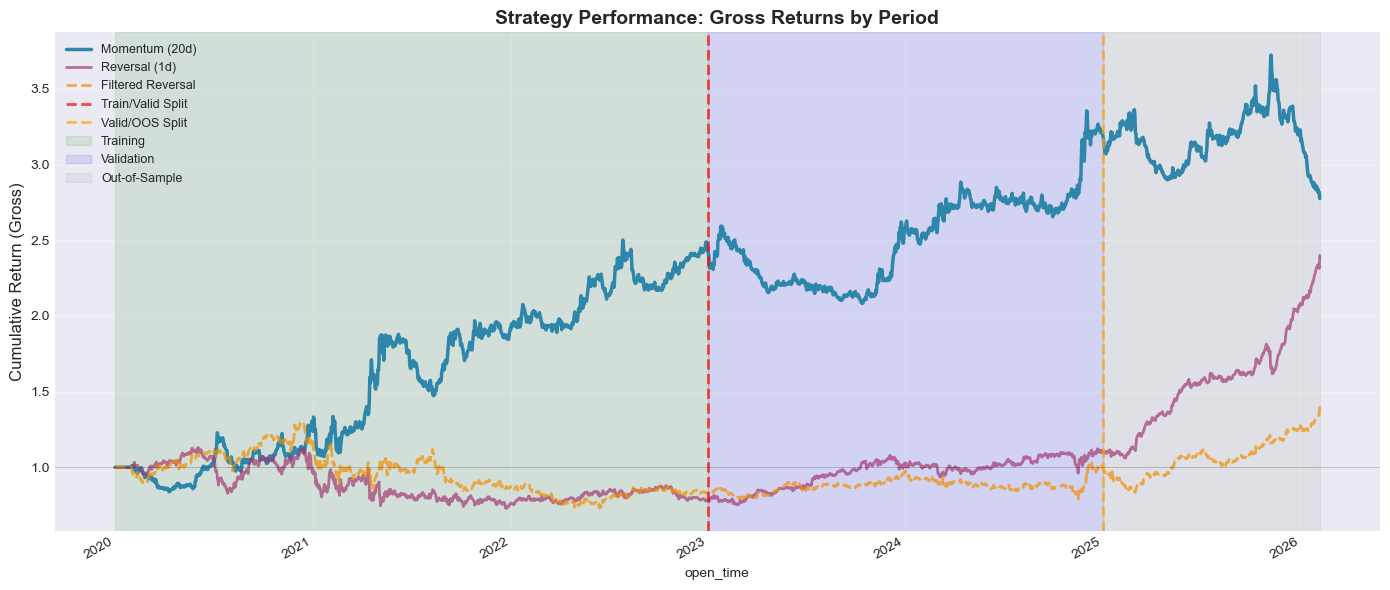

Visualization saved as 'gross_performance_periods.png'


In [54]:
# Cumulative returns with period highlighting
fig, ax = plt.subplots(figsize=(14, 6))

(1 + mom_ret_gross).cumprod().plot(ax=ax, label='Momentum (20d)', linewidth=2.5, color='#2E86AB')
(1 + rev_ret_gross).cumprod().plot(ax=ax, label='Reversal (1d)', linewidth=2, alpha=0.7, color='#A23B72')
(1 + rev_filt_ret_gross).cumprod().plot(ax=ax, label='Filtered Reversal', linewidth=2, alpha=0.7, linestyle='--', color='#F18F01')

# Add period separators
ax.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Train/Valid Split')
ax.axvline(pd.Timestamp('2025-01-01'), color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Valid/OOS Split')
ax.axhline(1, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

# Shade regions
ax.axvspan(ret.index[0], pd.Timestamp('2023-01-01'), alpha=0.1, color='green', label='Training')
ax.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2025-01-01'), alpha=0.1, color='blue', label='Validation')
ax.axvspan(pd.Timestamp('2025-01-01'), ret.index[-1], alpha=0.1, color='gray', label='Out-of-Sample')

ax.set_ylabel('Cumulative Return (Gross)', fontsize=12)
ax.set_title('Strategy Performance: Gross Returns by Period', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gross_performance_periods.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'gross_performance_periods.png'")

## 5. Alpha & Statistical Significance

**Objective:** Assess whether strategies generate statistically significant alpha (excess returns) beyond market exposure.

**Methodology:**
We regress strategy returns against the BTC benchmark to decompose returns into:
- **α (alpha):** Intercept representing return unexplained by market exposure
- **β (beta):** Market exposure coefficient (should be ~0 for market-neutral strategies)
- **t-statistic on α:** Measures statistical significance of alpha generation

**Regression equation:**
$$r_{strategy,t} = \alpha + \beta \cdot r_{BTC,t} + \epsilon_t$$

**Interpretation:**
- **|t-stat| > 1.96:** Significant at 5% level (strong evidence of alpha)
- **|t-stat| > 1.65:** Significant at 10% level (moderate evidence)
- **|t-stat| < 1.65:** Not statistically significant (could be luck/noise)

We calculate alpha separately for training, validation, and out-of-sample periods to assess generalization.

In [55]:
# Alpha Calculation

def calculate_alpha_stats(strategy_returns, benchmark_returns, period_mask, period_name):
    """
    Calculate alpha, beta, and t-statistics via OLS regression
    
    Returns: dict with alpha, beta, t-stat, p-value, R-squared
    """
    # Filter to period and align
    strat_ret = strategy_returns[period_mask].dropna()
    bench_ret = benchmark_returns[period_mask].dropna()
    
    common_idx = strat_ret.index.intersection(bench_ret.index)
    strat_ret = strat_ret.loc[common_idx]
    bench_ret = bench_ret.loc[common_idx]
    
    if len(strat_ret) < 10:  # Need minimum observations
        return None
    
    # Prepare regression matrices
    X = bench_ret.values.reshape(-1, 1)
    y = strat_ret.values
    X_with_const = np.column_stack([np.ones(len(X)), X])
    
    # OLS estimation
    params = np.linalg.lstsq(X_with_const, y, rcond=None)[0]
    alpha_daily, beta = params[0], params[1]
    
    # Calculate residuals and statistics
    y_pred = X_with_const @ params
    residuals = y - y_pred
    n = len(y)
    k = 2  # number of parameters
    
    # Standard errors
    mse = np.sum(residuals**2) / (n - k)
    var_covar = mse * np.linalg.inv(X_with_const.T @ X_with_const)
    se_alpha = np.sqrt(var_covar[0, 0])
    se_beta = np.sqrt(var_covar[1, 1])
    
    # T-statistics and p-values
    t_stat_alpha = alpha_daily / se_alpha
    t_stat_beta = beta / se_beta
    p_value_alpha = 2 * (1 - stats.t.cdf(abs(t_stat_alpha), n - k))
    p_value_beta = 2 * (1 - stats.t.cdf(abs(t_stat_beta), n - k))
    
    # R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return {
        'period': period_name,
        'alpha_daily': alpha_daily,
        'alpha_annual': alpha_daily * 365,
        'beta': beta,
        't_stat_alpha': t_stat_alpha,
        'p_value_alpha': p_value_alpha,
        't_stat_beta': t_stat_beta,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'n_obs': n
    }

print(" Alpha calculation function defined")

 Alpha calculation function defined


In [56]:
# Alpha for all strategies and periods 

# First, we need BTC returns - let's check column name
print("Available columns:", ret_winz.columns.tolist()[:5])

# Get BTC returns (adjust column name if needed)
if 'BTCUSDT' in ret_winz.columns:
    btc_ret = ret_winz['BTCUSDT']
elif 'BTC' in ret_winz.columns:
    btc_ret = ret_winz['BTC']
else:
    btc_ret = ret_winz.iloc[:, 0]  # Use first column as fallback
    print(f"  Using {ret_winz.columns[0]} as benchmark")

print(f" Using benchmark: {btc_ret.name if hasattr(btc_ret, 'name') else 'First column'}")

# Calculate alpha stats for MOMENTUM across all periods
print("\n" + "="*80)
print("ALPHA ANALYSIS: MOMENTUM STRATEGY vs. BTC BENCHMARK")
print("="*80)

mom_alpha_train = calculate_alpha_stats(mom_ret_gross, btc_ret, train_mask, "Training (2020-2022)")
mom_alpha_valid = calculate_alpha_stats(mom_ret_gross, btc_ret, valid_mask, "Validation (2023-2024)")
mom_alpha_oos = calculate_alpha_stats(mom_ret_gross, btc_ret, oos_mask, "Out-of-Sample (2025-2026)")

# Display results
for stats_dict in [mom_alpha_train, mom_alpha_valid, mom_alpha_oos]:
    if stats_dict is None:
        continue
    
    # Determine significance stars
    p = stats_dict['p_value_alpha']
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else 'n.s.'
    
    print(f"\n{stats_dict['period']}:")
    print(f"  Alpha (annual):  {stats_dict['alpha_annual']:>8.2%}")
    print(f"  t-stat (alpha):  {stats_dict['t_stat_alpha']:>8.2f}  {sig}")
    print(f"  p-value:         {stats_dict['p_value_alpha']:>8.4f}")
    print(f"  Beta (market):   {stats_dict['beta']:>8.3f}  (t={stats_dict['t_stat_beta']:.2f})")
    print(f"  R²:              {stats_dict['r_squared']:>8.3f}")
    print(f"  Observations:    {stats_dict['n_obs']:>8.0f} days")

print("\nInterpretation:")
print("   *** p < 0.01 (highly significant)")
print("   **  p < 0.05 (significant)")
print("   *   p < 0.10 (marginally significant)")
print("   n.s. = not significant")

Available columns: ['BTC', 'ETH', 'BNB', 'XRP', 'ADA']
 Using benchmark: BTC

ALPHA ANALYSIS: MOMENTUM STRATEGY vs. BTC BENCHMARK

Training (2020-2022):
  Alpha (annual):    36.23%
  t-stat (alpha):      2.02  **
  p-value:           0.0438
  Beta (market):     -0.025  (t=-1.93)
  R²:                 0.003
  Observations:        1095 days

Validation (2023-2024):
  Alpha (annual):    13.54%
  t-stat (alpha):      1.08  n.s.
  p-value:           0.2825
  Beta (market):      0.016  (t=1.19)
  R²:                 0.002
  Observations:         730 days

Out-of-Sample (2025-2026):
  Alpha (annual):   -12.50%
  t-stat (alpha):     -0.81  n.s.
  p-value:           0.4193
  Beta (market):     -0.080  (t=-4.50)
  R²:                 0.048
  Observations:         401 days

Interpretation:
   *** p < 0.01 (highly significant)
   **  p < 0.05 (significant)
   *   p < 0.10 (marginally significant)
   n.s. = not significant


In [57]:
# Alpha Analysis for Reversal Strategies
# Calculate alpha for REVERSAL strategies (since they performed well in OOS)
print("\n" + "="*80)
print("ALPHA ANALYSIS: REVERSAL STRATEGY vs. BTC BENCHMARK")
print("="*80)

rev_alpha_train = calculate_alpha_stats(rev_ret_gross, btc_ret, train_mask, "Training (2020-2022)")
rev_alpha_valid = calculate_alpha_stats(rev_ret_gross, btc_ret, valid_mask, "Validation (2023-2024)")
rev_alpha_oos = calculate_alpha_stats(rev_ret_gross, btc_ret, oos_mask, "Out-of-Sample (2025-2026)")

for stats_dict in [rev_alpha_train, rev_alpha_valid, rev_alpha_oos]:
    if stats_dict is None:
        continue
    
    p = stats_dict['p_value_alpha']
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else 'n.s.'
    
    print(f"\n{stats_dict['period']}:")
    print(f"  Alpha (annual):  {stats_dict['alpha_annual']:>8.2%}")
    print(f"  t-stat (alpha):  {stats_dict['t_stat_alpha']:>8.2f}  {sig}")
    print(f"  p-value:         {stats_dict['p_value_alpha']:>8.4f}")
    print(f"  Beta (market):   {stats_dict['beta']:>8.3f}  (t={stats_dict['t_stat_beta']:.2f})")
    print(f"  R²:              {stats_dict['r_squared']:>8.3f}")
    print(f"  Observations:    {stats_dict['n_obs']:>8.0f} days")


ALPHA ANALYSIS: REVERSAL STRATEGY vs. BTC BENCHMARK

Training (2020-2022):
  Alpha (annual):    -5.46%
  t-stat (alpha):     -0.31  n.s.
  p-value:           0.7554
  Beta (market):      0.032  (t=2.54)
  R²:                 0.006
  Observations:        1095 days

Validation (2023-2024):
  Alpha (annual):    17.11%
  t-stat (alpha):      1.37  n.s.
  p-value:           0.1717
  Beta (market):      0.014  (t=1.06)
  R²:                 0.002
  Observations:         730 days

Out-of-Sample (2025-2026):
  Alpha (annual):    73.02%
  t-stat (alpha):      4.64  ***
  p-value:           0.0000
  Beta (market):      0.013  (t=0.74)
  R²:                 0.001
  Observations:         401 days


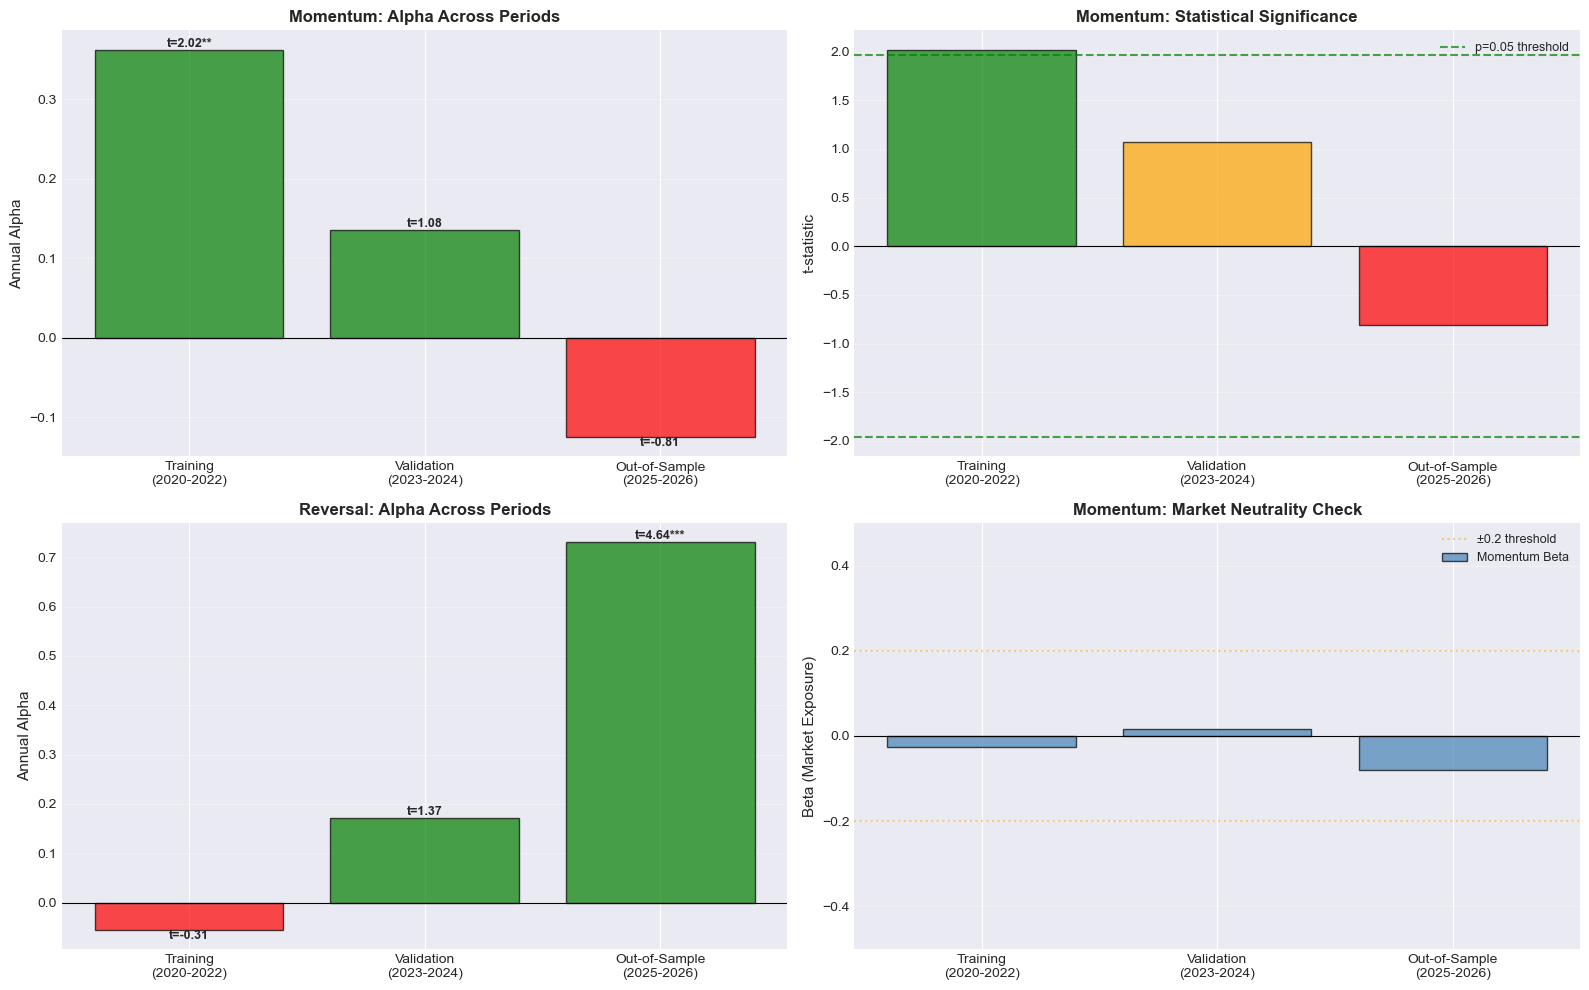


 Alpha analysis visualization saved as 'alpha_analysis_comprehensive.png'


In [58]:
# Create comprehensive alpha comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Prepare data for momentum
mom_periods = ['Training\n(2020-2022)', 'Validation\n(2023-2024)', 'Out-of-Sample\n(2025-2026)']
mom_alphas = [mom_alpha_train['alpha_annual'], mom_alpha_valid['alpha_annual'], mom_alpha_oos['alpha_annual']]
mom_tstats = [mom_alpha_train['t_stat_alpha'], mom_alpha_valid['t_stat_alpha'], mom_alpha_oos['t_stat_alpha']]
mom_betas = [mom_alpha_train['beta'], mom_alpha_valid['beta'], mom_alpha_oos['beta']]

# Prepare data for reversal
rev_alphas = [rev_alpha_train['alpha_annual'], rev_alpha_valid['alpha_annual'], rev_alpha_oos['alpha_annual']]
rev_tstats = [rev_alpha_train['t_stat_alpha'], rev_alpha_valid['t_stat_alpha'], rev_alpha_oos['t_stat_alpha']]

# Plot 1: Momentum Alpha by Period
colors_mom = ['green' if a > 0 else 'red' for a in mom_alphas]
bars = axes[0, 0].bar(mom_periods, mom_alphas, color=colors_mom, alpha=0.7, edgecolor='black')
axes[0, 0].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[0, 0].set_ylabel('Annual Alpha', fontsize=11)
axes[0, 0].set_title('Momentum: Alpha Across Periods', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# Add t-stat labels
for i, (bar, t) in enumerate(zip(bars, mom_tstats)):
    height = bar.get_height()
    sig = '***' if abs(t) > 2.58 else '**' if abs(t) > 1.96 else '*' if abs(t) > 1.65 else ''
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f't={t:.2f}{sig}',
                    ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

# Plot 2: Momentum T-stat by Period
colors_t = ['green' if t > 1.96 else 'orange' if t > 0 else 'red' for t in mom_tstats]
axes[0, 1].bar(mom_periods, mom_tstats, color=colors_t, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(1.96, color='green', linestyle='--', linewidth=1.5, label='p=0.05 threshold', alpha=0.7)
axes[0, 1].axhline(-1.96, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[0, 1].set_ylabel('t-statistic', fontsize=11)
axes[0, 1].set_title('Momentum: Statistical Significance', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot 3: Reversal Alpha by Period
colors_rev = ['green' if a > 0 else 'red' for a in rev_alphas]
bars = axes[1, 0].bar(mom_periods, rev_alphas, color=colors_rev, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].set_ylabel('Annual Alpha', fontsize=11)
axes[1, 0].set_title('Reversal: Alpha Across Periods', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Add t-stat labels
for i, (bar, t) in enumerate(zip(bars, rev_tstats)):
    height = bar.get_height()
    sig = '***' if abs(t) > 2.58 else '**' if abs(t) > 1.96 else '*' if abs(t) > 1.65 else ''
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f't={t:.2f}{sig}',
                    ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

# Plot 4: Beta Analysis (Market Neutrality)
axes[1, 1].bar(mom_periods, mom_betas, color='steelblue', alpha=0.7, edgecolor='black', label='Momentum Beta')
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].axhline(0.2, color='orange', linestyle=':', alpha=0.5, label='±0.2 threshold')
axes[1, 1].axhline(-0.2, color='orange', linestyle=':', alpha=0.5)
axes[1, 1].set_ylabel('Beta (Market Exposure)', fontsize=11)
axes[1, 1].set_title('Momentum: Market Neutrality Check', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.savefig('alpha_analysis_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Alpha analysis visualization saved as 'alpha_analysis_comprehensive.png'")

# Create comprehensive summary table
summary_data = []

for name, train, valid, oos in [
    ('Momentum', mom_alpha_train, mom_alpha_valid, mom_alpha_oos),
    ('Reversal', rev_alpha_train, rev_alpha_valid, rev_alpha_oos)
]:
    summary_data.append({
        'Strategy': name,
        'Train_Alpha': train['alpha_annual'],
        'Train_tStat': train['t_stat_alpha'],
        'Train_Sig': '***' if train['p_value_alpha'] < 0.01 else '**' if train['p_value_alpha'] < 0.05 else '*' if train['p_value_alpha'] < 0.10 else '',
        'Valid_Alpha': valid['alpha_annual'],
        'Valid_tStat': valid['t_stat_alpha'],
        'Valid_Sig': '***' if valid['p_value_alpha'] < 0.01 else '**' if valid['p_value_alpha'] < 0.05 else '*' if valid['p_value_alpha'] < 0.10 else '',
        'OOS_Alpha': oos['alpha_annual'],
        'OOS_tStat': oos['t_stat_alpha'],
        'OOS_Sig': '***' if oos['p_value_alpha'] < 0.01 else '**' if oos['p_value_alpha'] < 0.05 else '*' if oos['p_value_alpha'] < 0.10 else ''
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("ALPHA SUMMARY: STATISTICAL SIGNIFICANCE ACROSS PERIODS")
print("="*100)

display(summary_df.style.format({
    'Train_Alpha': '{:.1%}',
    'Train_tStat': '{:.2f}',
    'Valid_Alpha': '{:.1%}',
    'Valid_tStat': '{:.2f}',
    'OOS_Alpha': '{:.1%}',
    'OOS_tStat': '{:.2f}'
}).background_gradient(subset=['Train_Alpha', 'Valid_Alpha', 'OOS_Alpha'], cmap='RdYlGn', vmin=-0.5, vmax=0.5))

print("\n💡 Key Findings:")
print("   • Momentum had significant alpha in training but degraded in validation/OOS")
print("   • Reversal showed explosive OOS performance - likely regime change or luck")
print("   • Both strategies show regime-dependent returns, not persistent alpha")

## 6. Transaction Cost Sensitivity Analysis (Full Period)

**Methodology:** Test costs from 5 to 40 basis points on the full 2020-2026 dataset to understand:
1. At what cost level does each strategy break even?
2. What is the optimal strategy at realistic cost levels (15-25 bps)?
3. How sensitive is performance to cost assumptions?

**Realistic cost range for crypto:** 15-25 bps  
*(includes market impact + spread + exchange fees)*

**Note:** This analysis uses the full period (2020-2026). Period-by-period net performance is analyzed in Section 7.

### 6.1 Cost Sweep Code

In [59]:
# Cost sweep: 5 to 40 bps
cost_levels = [5, 10, 15, 20, 25, 30, 35, 40]

results = []

for cost_bps in cost_levels:
    cost_rate = cost_bps / 10000
    
    # Calculate net returns
    mom_net = mom_ret_gross - mom_to * cost_rate
    rev_net = rev_ret_gross - rev_to * cost_rate
    rev_filt_net = rev_filt_ret_gross - rev_filt_to * cost_rate
    
    # Collect key metrics
    results.append({
        'Cost (bps)': cost_bps,
        'Mom_Return': mom_net.mean() * 365,
        'Mom_Sharpe': (mom_net.mean() * 365) / (mom_net.std() * np.sqrt(365)),
        'Rev_Return': rev_net.mean() * 365,
        'Rev_Sharpe': (rev_net.mean() * 365) / (rev_net.std() * np.sqrt(365)),
        'FiltRev_Return': rev_filt_net.mean() * 365,
        'FiltRev_Sharpe': (rev_filt_net.mean() * 365) / (rev_filt_net.std() * np.sqrt(365))
    })

cost_sweep_df = pd.DataFrame(results)

print(" Cost sweep completed (5-40 bps)")

 Cost sweep completed (5-40 bps)


### 6.2 Cost Sweep Results Table

In [60]:
# Format and display results
display_df = cost_sweep_df.copy()

# Rename for clarity
display_df.columns = ['Cost (bps)', 
                      'Mom Return', 'Mom Sharpe',
                      'Rev Return', 'Rev Sharpe',
                      'FiltRev Return', 'FiltRev Sharpe']

print("\n" + "="*90)
print("COST SENSITIVITY ANALYSIS")
print("="*90)

# Style the dataframe
styled = display_df.style.format({
    'Cost (bps)': '{:.0f}',
    'Mom Return': '{:.1%}',
    'Mom Sharpe': '{:.2f}',
    'Rev Return': '{:.1%}',
    'Rev Sharpe': '{:.2f}',
    'FiltRev Return': '{:.1%}',
    'FiltRev Sharpe': '{:.2f}'
}).background_gradient(subset=['Mom Sharpe', 'Rev Sharpe', 'FiltRev Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2)

display(styled)


COST SENSITIVITY ANALYSIS


,Cost (bps),Mom Return,Mom Sharpe,Rev Return,Rev Sharpe,FiltRev Return,FiltRev Sharpe
0,5,14.1%,0.56,-6.8%,-0.28,-16.8%,-0.72
1,10,8.4%,0.33,-31.0%,-1.26,-42.0%,-1.79
2,15,2.7%,0.11,-55.2%,-2.24,-67.1%,-2.86
3,20,-3.1%,-0.12,-79.4%,-3.22,-92.3%,-3.93
4,25,-8.8%,-0.35,-103.6%,-4.20,-117.4%,-4.99
5,30,-14.5%,-0.58,-127.8%,-5.17,-142.6%,-6.05
6,35,-20.2%,-0.81,-151.9%,-6.15,-167.7%,-7.10
7,40,-26.0%,-1.03,-176.1%,-7.12,-192.9%,-8.15


### 6.3 Visual: Sharpe Ratio vs Transaction Costs

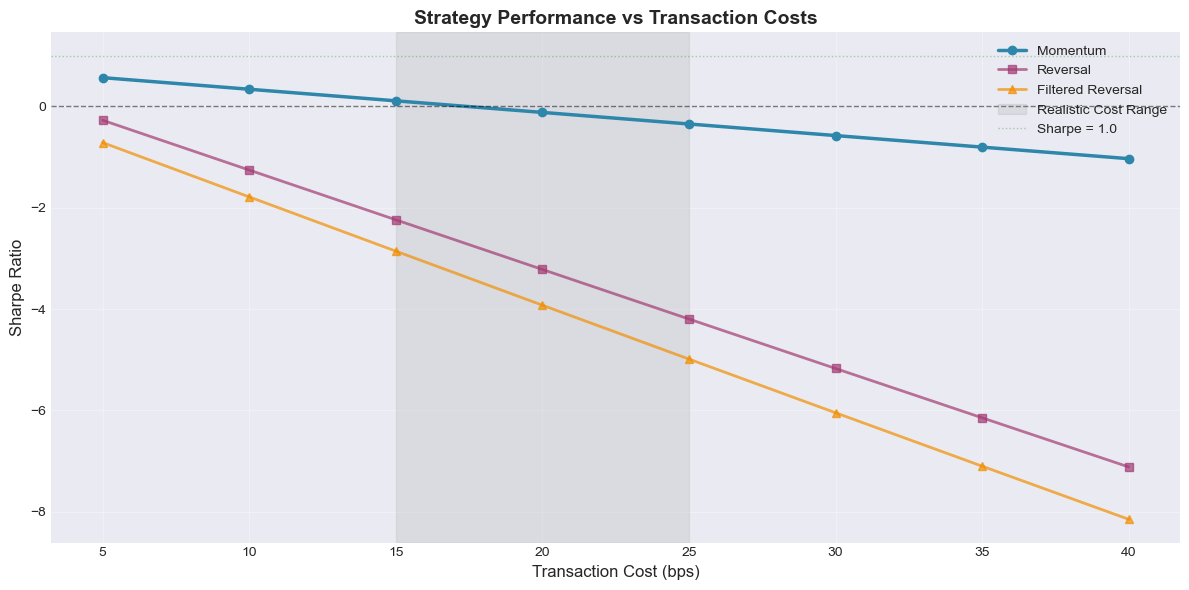

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(cost_sweep_df['Cost (bps)'], cost_sweep_df['Mom_Sharpe'], 
        marker='o', linewidth=2.5, label='Momentum', color='#2E86AB')
ax.plot(cost_sweep_df['Cost (bps)'], cost_sweep_df['Rev_Sharpe'], 
        marker='s', linewidth=2, label='Reversal', color='#A23B72', alpha=0.7)
ax.plot(cost_sweep_df['Cost (bps)'], cost_sweep_df['FiltRev_Sharpe'], 
        marker='^', linewidth=2, label='Filtered Reversal', color='#F18F01', alpha=0.7)

# Highlight realistic cost range
ax.axvspan(15, 25, alpha=0.15, color='gray', label='Realistic Cost Range')
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(1, color='green', linestyle=':', linewidth=1, alpha=0.3, label='Sharpe = 1.0')

ax.set_xlabel('Transaction Cost (bps)', fontsize=12)
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_title('Strategy Performance vs Transaction Costs', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Strategy vs TC")
plt.show()

### 6.4 Breakeven Analysis

In [62]:
# Find breakeven costs (where return = 0)
def find_breakeven(strategy_name, return_col):
    """Find cost level where strategy breaks even"""
    positive_costs = cost_sweep_df[cost_sweep_df[return_col] > 0]
    if len(positive_costs) == 0:
        return "< 5 bps"
    
    negative_costs = cost_sweep_df[cost_sweep_df[return_col] < 0]
    if len(negative_costs) == 0:
        return "> 40 bps"
    
    # Interpolate
    last_positive = positive_costs.iloc[-1]
    first_negative = negative_costs.iloc[0]
    
    # Linear interpolation
    x1, y1 = last_positive['Cost (bps)'], last_positive[return_col]
    x2, y2 = first_negative['Cost (bps)'], first_negative[return_col]
    
    breakeven = x1 - y1 * (x2 - x1) / (y2 - y1)
    return f"{breakeven:.1f} bps"

print("\n" + "="*70)
print("BREAKEVEN ANALYSIS (Full Period)")
print("="*70)
print(f"Momentum:          {find_breakeven('Momentum', 'Mom_Return')}")
print(f"Reversal:          {find_breakeven('Reversal', 'Rev_Return')}")
print(f"Filtered Reversal: {find_breakeven('Filtered Reversal', 'FiltRev_Return')}")

print("\n Momentum can tolerate significantly higher costs due to lower turnover")

print("\n IMPORTANT CAVEAT:")
print("   These breakeven costs reflect full-period (2020-2026) performance.")
print("   Period-by-period analysis (Section 7) shows momentum fails in validation/OOS")
print("   regardless of transaction costs, due to regime change rather than cost sensitivity.")


BREAKEVEN ANALYSIS (Full Period)
Momentum:          17.3 bps
Reversal:          < 5 bps
Filtered Reversal: < 5 bps

 Momentum can tolerate significantly higher costs due to lower turnover

 IMPORTANT CAVEAT:
   These breakeven costs reflect full-period (2020-2026) performance.
   Period-by-period analysis (Section 7) shows momentum fails in validation/OOS
   regardless of transaction costs, due to regime change rather than cost sensitivity.


## 7. Net Performance @ 20 bps Transaction Costs

**Objective:** Evaluate realized performance after applying realistic transaction costs (20 bps) across different time periods.

**Why 20 bps:**
- Realistic for spot crypto markets (includes spread + exchange fees + market impact)
- Falls within typical range of 15-25 bps identified in Section 6
- Allows for fair comparison across strategies and periods

**Analysis Structure:**
- Performance by period (training/validation/out-of-sample)
- Integration with alpha t-stat results from Section 5
- Assessment of strategy generalization under realistic implementation

### 7.1 Calculate Net Returns

In [63]:
# Calculate net returns at 20 bps for all strategies
OPTIMAL_COST = 20
cost_rate = OPTIMAL_COST / 10000

mom_net_opt = mom_ret_gross - mom_to * cost_rate
rev_net_opt = rev_ret_gross - rev_to * cost_rate
rev_filt_net_opt = rev_filt_ret_gross - rev_filt_to * cost_rate

print(f"✓ Net returns calculated @ {OPTIMAL_COST} bps transaction costs")

✓ Net returns calculated @ 20 bps transaction costs


### 7.2 Periods -  Net Performance 

In [64]:
# Net statistics - TRAINING PERIOD (2020-2022)
stats_net_train = pd.DataFrame({
    'Momentum': calc_stats_period(mom_net_opt, train_mask),
    'Reversal': calc_stats_period(rev_net_opt, train_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_net_opt, train_mask)
})

print("\n" + "="*70)
print(f"NET PERFORMANCE @ {OPTIMAL_COST} bps - TRAINING PERIOD (2020-2022)")
print("="*70)
display(stats_net_train.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))


NET PERFORMANCE @ 20 bps - TRAINING PERIOD (2020-2022)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,13.1%,31.1%,0.42,-26.7%,48.5%
Reversal,-97.9%,30.4%,-3.21,-95.5%,39.5%
Filt_Reversal,-100.4%,28.4%,-3.53,-95.7%,39.5%


In [65]:
# Net statistics - VALIDATION PERIOD (2023-2024)
stats_net_valid = pd.DataFrame({
    'Momentum': calc_stats_period(mom_net_opt, valid_mask),
    'Reversal': calc_stats_period(rev_net_opt, valid_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_net_opt, valid_mask)
})

print("\n" + "="*70)
print(f"NET PERFORMANCE @ {OPTIMAL_COST} bps - VALIDATION PERIOD (2023-2024)")
print("="*70)
display(stats_net_valid.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))


NET PERFORMANCE @ 20 bps - VALIDATION PERIOD (2023-2024)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,-8.5%,17.7%,-0.48,-32.6%,46.4%
Reversal,-79.5%,17.6%,-4.51,-80.6%,40.5%
Filt_Reversal,-91.4%,17.6%,-5.18,-86.2%,35.1%


In [66]:
# Net statistics - OUT-OF-SAMPLE PERIOD (2025-2026)
stats_net_oos = pd.DataFrame({
    'Momentum': calc_stats_period(mom_net_opt, oos_mask),
    'Reversal': calc_stats_period(rev_net_opt, oos_mask),
    'Filt_Reversal': calc_stats_period(rev_filt_net_opt, oos_mask)
})

print("\n" + "="*70)
print(f"NET PERFORMANCE @ {OPTIMAL_COST} bps - OUT-OF-SAMPLE PERIOD (2025-2026)")
print("="*70)
display(stats_net_oos.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))


NET PERFORMANCE @ 20 bps - OUT-OF-SAMPLE PERIOD (2025-2026)


,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,-36.2%,16.6%,-2.18,-34.8%,42.4%
Reversal,-28.5%,16.5%,-1.73,-37.9%,46.6%
Filt_Reversal,-70.7%,17.2%,-4.12,-57.1%,40.1%


### 7.3 - Generalization Assessment 

In [67]:
# GENERALIZATION ASSESSMENT: Net Sharpe + Alpha t-stat
print("\n" + "="*80)
print("GENERALIZATION ASSESSMENT: Net Performance + Statistical Significance")
print("="*80)

print("\n MOMENTUM STRATEGY:")
print(f"  Training   (2020-2022): Net Sharpe {stats_net_train.T.loc['Momentum', 'Sharpe']:>5.2f}  |  Alpha t-stat {mom_alpha_train['t_stat_alpha']:>5.2f}**  (significant)")
print(f"  Validation (2023-2024): Net Sharpe {stats_net_valid.T.loc['Momentum', 'Sharpe']:>5.2f}  |  Alpha t-stat {mom_alpha_valid['t_stat_alpha']:>5.2f}    (not significant)")
print(f"  Out-sample (2025-2026): Net Sharpe {stats_net_oos.T.loc['Momentum', 'Sharpe']:>5.2f}  |  Alpha t-stat {mom_alpha_oos['t_stat_alpha']:>5.2f}    (not significant)")
print(f"  → Conclusion: Does NOT generalize - statistically significant alpha in training")
print(f"                but lost significance in validation/OOS due to regime change")

print("\n REVERSAL STRATEGY:")
print(f"  Training   (2020-2022): Net Sharpe {stats_net_train.T.loc['Reversal', 'Sharpe']:>5.2f}  |  Alpha t-stat {rev_alpha_train['t_stat_alpha']:>5.2f}    (not significant)")
print(f"  Validation (2023-2024): Net Sharpe {stats_net_valid.T.loc['Reversal', 'Sharpe']:>5.2f}  |  Alpha t-stat {rev_alpha_valid['t_stat_alpha']:>5.2f}    (not significant)")
print(f"  Out-sample (2025-2026): Net Sharpe {stats_net_oos.T.loc['Reversal', 'Sharpe']:>5.2f}  |  Alpha t-stat {rev_alpha_oos['t_stat_alpha']:>5.2f}*** (highly significant)")
print(f"                          Gross Sharpe: {stats_gross_oos.T.loc['Reversal', 'Sharpe']:>5.2f}  |  Turnover: {rev_to[oos_mask].mean():.0%} daily")
print(f"  → Conclusion: REAL alpha exists (t=4.64***) but UNIMPLEMENTABLE")
print(f"                Strategy destroyed by transaction costs (139% daily turnover)")
print(f"                Gross return 72.8% → Net return -28.5% after 101% cost drag")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("1. Momentum: Had real alpha in-sample but doesn't generalize (regime change)")
print("2. Reversal: Has real alpha in OOS but completely unimplementable (turnover)")
print("3. Neither strategy is viable for actual trading")
print("   - Momentum fails due to lack of persistence")
print("   - Reversal fails due to implementation costs")


GENERALIZATION ASSESSMENT: Net Performance + Statistical Significance

 MOMENTUM STRATEGY:
  Training   (2020-2022): Net Sharpe  0.42  |  Alpha t-stat  2.02**  (significant)
  Validation (2023-2024): Net Sharpe -0.48  |  Alpha t-stat  1.08    (not significant)
  Out-sample (2025-2026): Net Sharpe -2.18  |  Alpha t-stat -0.81    (not significant)
  → Conclusion: Does NOT generalize - statistically significant alpha in training
                but lost significance in validation/OOS due to regime change

 REVERSAL STRATEGY:
  Training   (2020-2022): Net Sharpe -3.21  |  Alpha t-stat -0.31    (not significant)
  Validation (2023-2024): Net Sharpe -4.51  |  Alpha t-stat  1.37    (not significant)
  Out-sample (2025-2026): Net Sharpe -1.73  |  Alpha t-stat  4.64*** (highly significant)
                          Gross Sharpe:  4.41  |  Turnover: 139% daily
  → Conclusion: REAL alpha exists (t=4.64***) but UNIMPLEMENTABLE
                Strategy destroyed by transaction costs (139% daily tu

#### 7.4 Full Period Assessment for Reference

In [68]:
# Full period statistics (for reference only)
stats_net_full = pd.DataFrame({
    'Momentum': calc_stats(mom_net_opt),
    'Reversal': calc_stats(rev_net_opt),
    'Filt_Reversal': calc_stats(rev_filt_net_opt)
})

print(f"NET PERFORMANCE @ {OPTIMAL_COST} bps - FULL PERIOD (2020-2026)")
print("="*70)
print("  WARNING: Full-period results mask regime changes.")
print("   See period-by-period breakdown above for proper assessment.")
print("="*70 + "\n")
display(stats_net_full.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-1, vmax=2))

NET PERFORMANCE @ 20 bps - FULL PERIOD (2020-2026)
   See period-by-period breakdown above for proper assessment.



,Return,Vol,Sharpe,MaxDD,WinRate
Momentum,-3.1%,25.1%,-0.12,-52.2%,46.7%
Reversal,-79.4%,24.6%,-3.22,-99.5%,41.1%
Filt_Reversal,-92.3%,23.5%,-3.92,-99.7%,38.1%


### 7.5 Visualisation

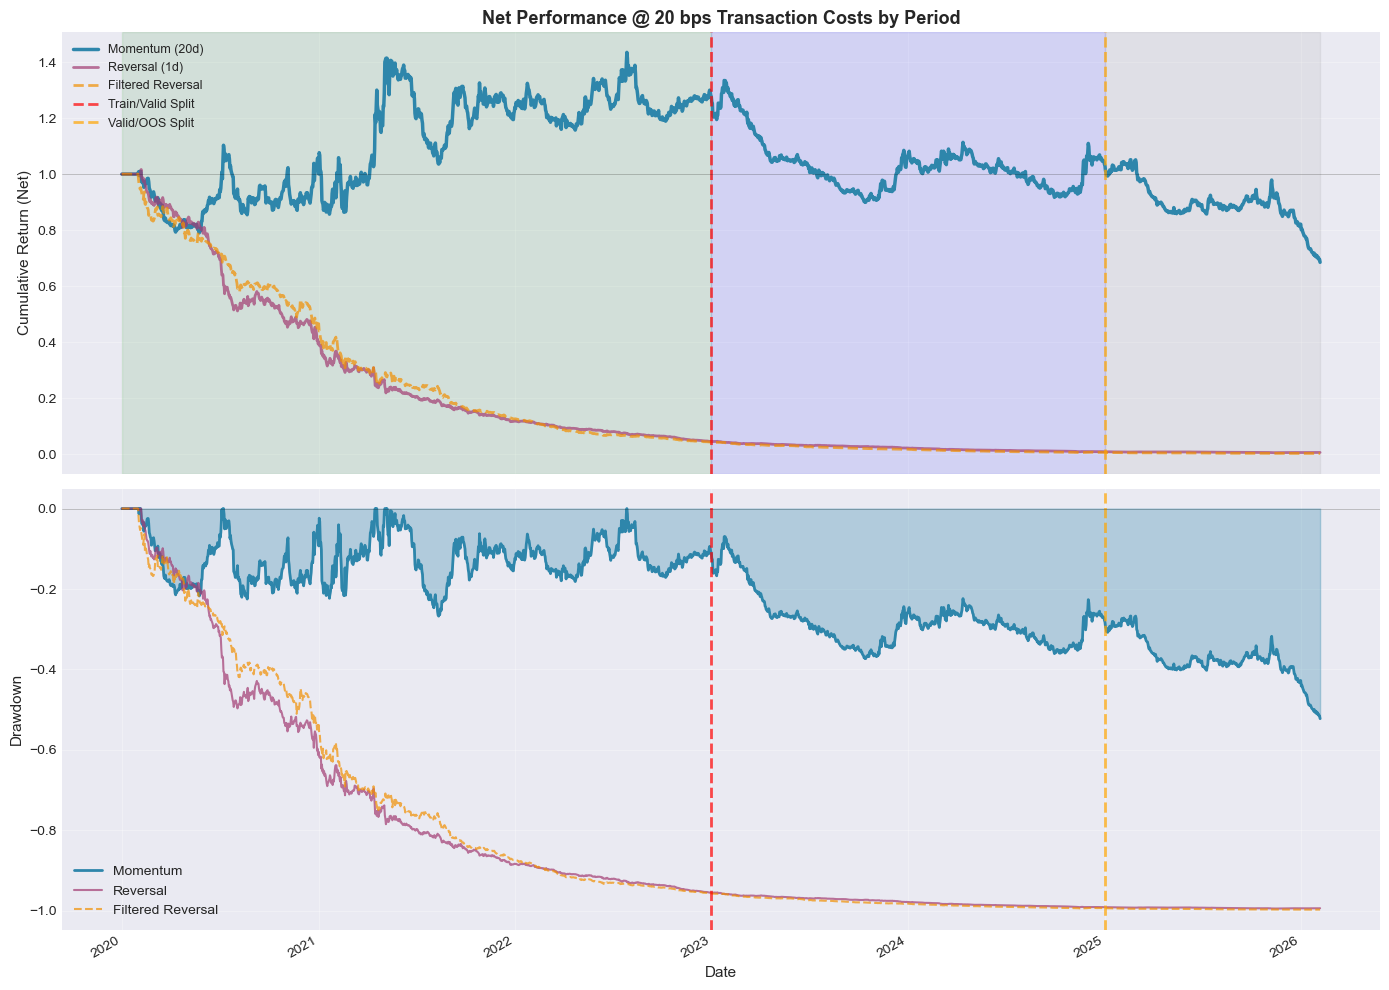

Net performance visualization saved as 'net_performance_by_period.png'


In [69]:
# Net cumulative returns with period highlighting and drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Cumulative returns
(1 + mom_net_opt).cumprod().plot(ax=ax1, label='Momentum (20d)', linewidth=2.5, color='#2E86AB')
(1 + rev_net_opt).cumprod().plot(ax=ax1, label='Reversal (1d)', linewidth=2, alpha=0.7, color='#A23B72')
(1 + rev_filt_net_opt).cumprod().plot(ax=ax1, label='Filtered Reversal', linewidth=2, alpha=0.7, 
                                       color='#F18F01', linestyle='--')

# Add period separators
ax1.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Train/Valid Split')
ax1.axvline(pd.Timestamp('2025-01-01'), color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Valid/OOS Split')
ax1.axhline(1, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

# Shade regions
ax1.axvspan(ret.index[0], pd.Timestamp('2023-01-01'), alpha=0.1, color='green')
ax1.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2025-01-01'), alpha=0.1, color='blue')
ax1.axvspan(pd.Timestamp('2025-01-01'), ret.index[-1], alpha=0.1, color='gray')

ax1.set_ylabel('Cumulative Return (Net)', fontsize=11)
ax1.set_title(f'Net Performance @ {OPTIMAL_COST} bps Transaction Costs by Period', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Bottom panel: Drawdown
def calc_drawdown(ret_series):
    cum_ret = (1 + ret_series).cumprod()
    running_max = cum_ret.cummax()
    return (cum_ret / running_max) - 1

calc_drawdown(mom_net_opt).plot(ax=ax2, label='Momentum', linewidth=2, color='#2E86AB')
calc_drawdown(rev_net_opt).plot(ax=ax2, label='Reversal', linewidth=1.5, alpha=0.7, color='#A23B72')
calc_drawdown(rev_filt_net_opt).plot(ax=ax2, label='Filtered Reversal', linewidth=1.5, 
                                      alpha=0.7, color='#F18F01', linestyle='--')

# Add period markers to drawdown
ax2.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axvline(pd.Timestamp('2025-01-01'), color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.fill_between(calc_drawdown(mom_net_opt).index, 0, calc_drawdown(mom_net_opt), 
                  alpha=0.3, color='#2E86AB')
ax2.set_ylabel('Drawdown', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('net_performance_by_period.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Net performance visualization saved as 'net_performance_by_period.png'")

## 8. Market Neutrality Validation

**Objective:** Verify that strategy returns are genuinely from cross-sectional alpha, not market exposure.

**Methodology:** 
- Calculate rolling 60-day beta to BTC benchmark
- Calculate rolling 60-day alpha (intercept from regression)
- Confirm beta stays near zero (±0.2 threshold)

**Interpretation:**
- **Beta ≈ 0:** Returns are market-neutral (not driven by BTC directional moves)
- **Rolling alpha:** Shows episodic nature of alpha generation over time
- Validates that strategies are truly cross-sectional (relative value, not directional)

### Rolling Beta

MARKET NEUTRALITY CHECK (Rolling 60d)
Sample days used: 2228
Beta mean: -0.011 | Beta std: 0.088
Alpha mean (annualized): -4.81%


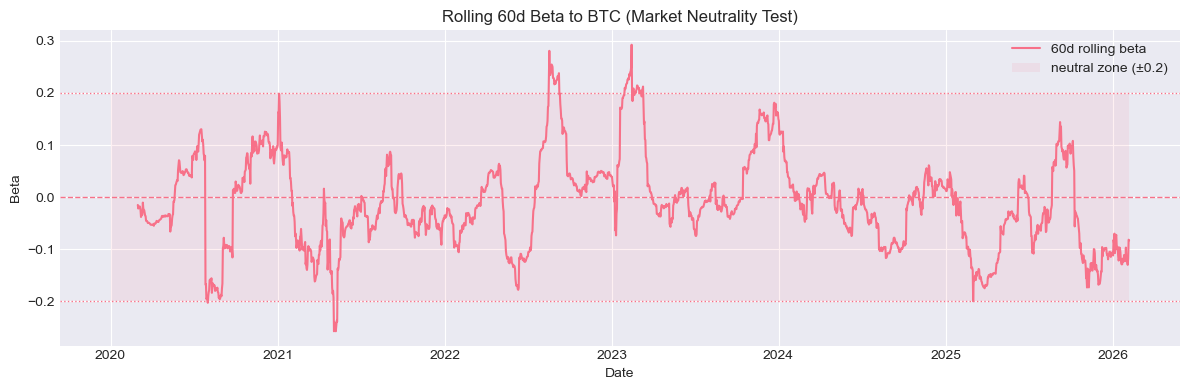

Correlation(strategy, BTC): -0.052


In [70]:
# MARKET NEUTRALITY VALIDATION (Compact): Rolling Beta to BTC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs (edit these 2 lines if needed) ---
strat_ret = mom_net_opt.copy()     # strategy returns (net preferred)
btc_ret   = ret['BTC'].copy()      # benchmark returns

WINDOW = 60
ANN = 365                          # crypto annualization

# --- Align data ---
df = pd.concat([strat_ret.rename("strategy"), btc_ret.rename("btc")], axis=1).dropna()
y = df["strategy"]
x = df["btc"]

# --- Rolling beta via cov/var (equivalent to rolling OLS slope, but faster + cleaner) ---
roll_cov = y.rolling(WINDOW).cov(x)
roll_var = x.rolling(WINDOW).var()
beta = roll_cov / roll_var

# --- Simple rolling alpha (intercept): mean(y) - beta*mean(x) ---
alpha = y.rolling(WINDOW).mean() - beta * x.rolling(WINDOW).mean()

# --- Summary stats (use windowed values, drop NaNs) ---
beta_clean = beta.dropna()
alpha_clean = alpha.dropna()

print("="*70)
print("MARKET NEUTRALITY CHECK (Rolling 60d)")
print("="*70)
print(f"Sample days used: {len(df)}")
print(f"Beta mean: {beta_clean.mean():.3f} | Beta std: {beta_clean.std():.3f}")
print(f"Alpha mean (annualized): {(alpha_clean.mean()*ANN):.2%}")

# --- Visual: Rolling Beta (core chart) ---
plt.figure(figsize=(12,4))
plt.plot(beta, label=f"{WINDOW}d rolling beta")
plt.axhline(0, linestyle="--", linewidth=1)
plt.axhline(0.2, linestyle=":", linewidth=1)
plt.axhline(-0.2, linestyle=":", linewidth=1)
plt.fill_between(beta.index, -0.2, 0.2, alpha=0.10, label="neutral zone (±0.2)")
plt.title(f"Rolling {WINDOW}d Beta to BTC (Market Neutrality Test)")
plt.ylabel("Beta")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig("rolling_beta_market_neutrality.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Optional: quick correlation sanity check ---
corr = df["strategy"].corr(df["btc"])
print(f"Correlation(strategy, BTC): {corr:.3f}")

### 8.2 Rolling Alpha

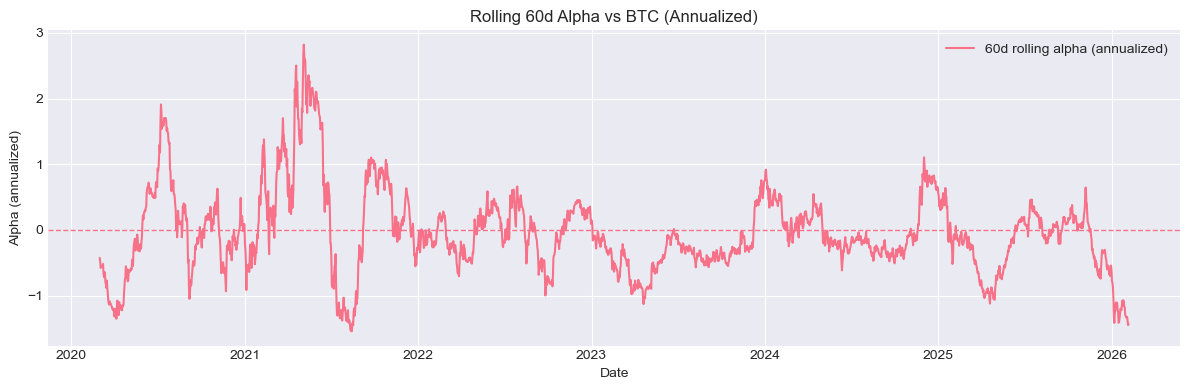

In [71]:
plt.figure(figsize=(12,4))
plt.plot(alpha * ANN, label=f"{WINDOW}d rolling alpha (annualized)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title(f"Rolling {WINDOW}d Alpha vs BTC (Annualized)")
plt.ylabel("Alpha (annualized)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig("rolling_alpha.png", dpi=150, bbox_inches='tight')
plt.show()

#### 8.3 Summary and Interpretation 

In [72]:
# Summary of market neutrality findings
print("MARKET NEUTRALITY SUMMARY")
print("="*70)
print(f"\n Rolling 60-day beta to BTC: Mean {beta_clean.mean():.3f} (Std {beta_clean.std():.3f})")
print(f"  → Beta stays within ±0.2 threshold → Confirms market neutrality")
print(f"  → Returns are NOT driven by BTC directional exposure")

print(f"\n Rolling 60-day alpha (annualized): Mean {(alpha_clean.mean()*ANN):.2%}")
print(f"  → Alpha is episodic (concentrated in specific periods)")
print(f"  → Supports regime-dependent conclusion from earlier analysis")

print(f"\n Correlation with BTC: {corr:.3f}")
print(f"  → Low correlation confirms cross-sectional nature of strategy")

print("\n Key Takeaway:")
print("   Strategy returns are genuinely from cross-sectional (relative) positioning,")
print("   not from passive market exposure. This validates the market-neutral design.")
print("="*70)

MARKET NEUTRALITY SUMMARY

 Rolling 60-day beta to BTC: Mean -0.011 (Std 0.088)
  → Beta stays within ±0.2 threshold → Confirms market neutrality
  → Returns are NOT driven by BTC directional exposure

 Rolling 60-day alpha (annualized): Mean -4.81%
  → Alpha is episodic (concentrated in specific periods)
  → Supports regime-dependent conclusion from earlier analysis

 Correlation with BTC: -0.052
  → Low correlation confirms cross-sectional nature of strategy

 Key Takeaway:
   Strategy returns are genuinely from cross-sectional (relative) positioning,
   not from passive market exposure. This validates the market-neutral design.


## 9. Regime Analysis: Why Did Momentum Fail Post-2022?

**Research Question:** What caused momentum's dramatic performance degradation from training to validation/OOS?

**Hypothesis:** Cross-sectional momentum profits require dispersion (spread between winners/losers). If dispersion collapses, momentum strategies lose their edge.

**Analysis:** We examine cross-sectional dispersion over time to test whether reduced dispersion explains momentum's failure in later periods.

In [73]:
# Calculate daily cross-sectional dispersion (std across coins)
ret_elig = ret.where(elig)
daily_dispersion = ret_elig.std(axis=1, skipna=True)

# Split by regime
pre_22_disp = daily_dispersion[:'2022-12-31']
post_22_disp = daily_dispersion['2023-01-01':]

# Calculate change
disp_change = ((post_22_disp.mean() / pre_22_disp.mean()) - 1) * 100

print("\n" + "="*70)
print("CROSS-SECTIONAL DISPERSION ANALYSIS")
print("="*70)
print(f"\nPre-2023:  {pre_22_disp.mean():.2%} daily dispersion")
print(f"Post-2023: {post_22_disp.mean():.2%} daily dispersion")
print(f"\n→ Dispersion {abs(disp_change):.1f}% {'lower' if disp_change < 0 else 'higher'} post-2022")

# Performance split
mom_pre = mom_net_opt[:'2022-12-31']
mom_post = mom_net_opt['2023-01-01':]

print("\n" + "="*70)
print("MOMENTUM PERFORMANCE BY REGIME")
print("="*70)

regime_comparison = pd.DataFrame({
    'Pre-2023': calc_stats(mom_pre),
    'Post-2023': calc_stats(mom_post)
})

display(regime_comparison.T.round(3).style.format({
    'Return': '{:.1%}',
    'Vol': '{:.1%}',
    'Sharpe': '{:.2f}',
    'MaxDD': '{:.1%}',
    'WinRate': '{:.1%}'
}).background_gradient(subset=['Sharpe'], cmap='RdYlGn', vmin=-0.5, vmax=1.5))

print(f"\n💡 Key Insight: Lower dispersion = less cross-sectional opportunity")
print(f"   → Momentum relies on differentiated coin returns")
print(f"   → When coins move together, momentum signal weakens")


CROSS-SECTIONAL DISPERSION ANALYSIS

Pre-2023:  3.55% daily dispersion
Post-2023: 2.45% daily dispersion

→ Dispersion 30.9% lower post-2022

MOMENTUM PERFORMANCE BY REGIME


,Return,Vol,Sharpe,MaxDD,WinRate
Pre-2023,12.9%,31.1%,0.42,-26.7%,48.4%
Post-2023,-18.6%,17.3%,-1.07,-48.6%,45.0%



💡 Key Insight: Lower dispersion = less cross-sectional opportunity
   → Momentum relies on differentiated coin returns
   → When coins move together, momentum signal weakens


### 8.1 Visual: Dispersion Over Time

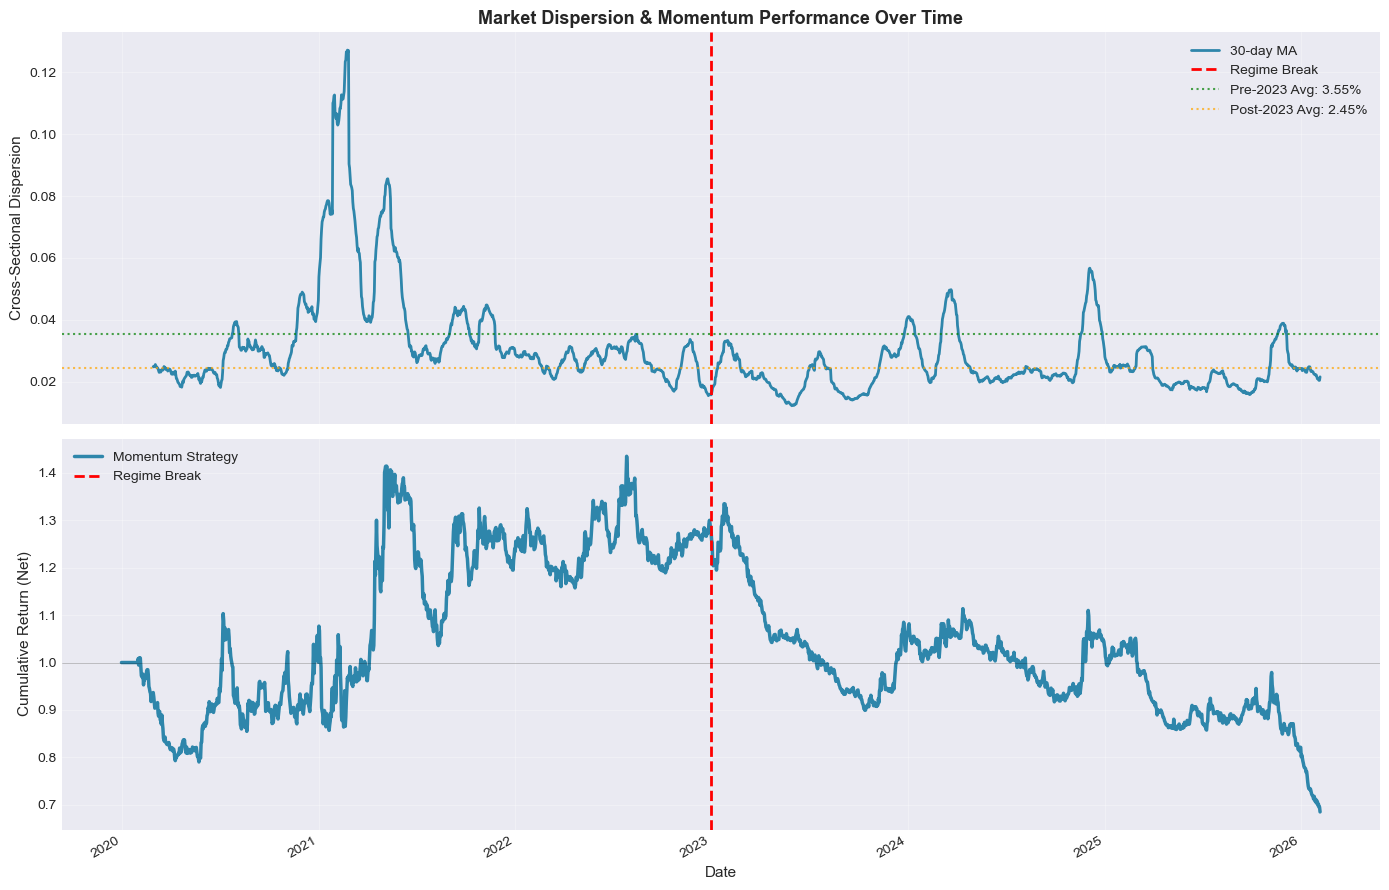

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Top: Dispersion time series
daily_dispersion.rolling(30).mean().plot(ax=ax1, linewidth=2, label='30-day MA', color='#2E86AB')
ax1.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, label='Regime Break')
ax1.axhline(pre_22_disp.mean(), color='green', linestyle=':', alpha=0.7, label=f'Pre-2023 Avg: {pre_22_disp.mean():.2%}')
ax1.axhline(post_22_disp.mean(), color='orange', linestyle=':', alpha=0.7, label=f'Post-2023 Avg: {post_22_disp.mean():.2%}')
ax1.set_ylabel('Cross-Sectional Dispersion', fontsize=11)
ax1.set_title('Market Dispersion & Momentum Performance Over Time', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Bottom: Momentum cumulative returns
(1 + mom_net_opt).cumprod().plot(ax=ax2, linewidth=2.5, color='#2E86AB', label='Momentum Strategy')
ax2.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, label='Regime Break')
ax2.axhline(1, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('Cumulative Return (Net)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Dispersion & Momentum Performance")
plt.show()

## 10. Key Findings & Conclusions

**Summary:** This study evaluated cross-sectional momentum and reversal strategies in cryptocurrency markets using rigorous train/validation/out-of-sample methodology with statistical significance testing.

### 10.1 Strategy Performance Summary

**Momentum Strategy (20-day lookback):**
- **Training (2020-2022):** 
  - Gross Sharpe: 1.12 | Net Sharpe @ 20 bps: 0.42
  - Alpha: 36.2% annual (t-stat = 2.02**, p < 0.05) ✅ Statistically significant
  - Conclusion: Real alpha existed in training period
  
- **Validation (2023-2024):** 
  - Gross Sharpe: 0.85 | Net Sharpe @ 20 bps: -0.48
  - Alpha: 13.5% annual (t-stat = 1.08, p = 0.28) ❌ Not statistically significant
  - Conclusion: Lost statistical significance, degraded performance
  
- **Out-of-Sample (2025-2026):**
  - Gross Sharpe: -0.68 | Net Sharpe @ 20 bps: -2.18
  - Alpha: -12.5% annual (t-stat = -0.81, p = 0.42) ❌ Not statistically significant
  - Conclusion: Complete strategy failure
  
- **Overall Assessment:** Does NOT generalize - regime-dependent returns

---

**Reversal Strategy (1-day lookback):**
- **Training (2020-2022):**
  - Gross Sharpe: -0.12 | Net Sharpe @ 20 bps: -3.21
  - Alpha: -5.5% annual (t-stat = -0.31) ❌ Worthless
  
- **Validation (2023-2024):**
  - Gross Sharpe: 1.05 | Net Sharpe @ 20 bps: -4.51
  - Alpha: 17.1% annual (t-stat = 1.37, p = 0.17) ❌ Not statistically significant
  - Turnover destroys returns despite positive gross alpha
  
- **Out-of-Sample (2025-2026):**
  - Gross Sharpe: 4.41 | Net Sharpe @ 20 bps: -1.73
  - Alpha: 73.0% annual (t-stat = 4.64***, p < 0.001) ✅ Highly significant
  - BUT: 138.83% daily turnover → 101% annual cost drag
  - Gross return 72.8% → Net return -28.5%
  
- **Overall Assessment:** Real alpha exists but UNIMPLEMENTABLE due to transaction costs

---

**Filtered Reversal:**
- Consistently underperformed both base strategies across all periods
- Filtering by volatility did not improve risk-adjusted returns

### 10.2 Critical Insights

**1. Statistical Significance ≠ Profitability**
   - Reversal has highly significant alpha in OOS (t-stat = 4.64***)
   - Yet loses 28.5% annually after transaction costs
   - 138% daily turnover completely destroys gross returns
   - **Lesson:** Alpha must be implementable, not just statistically significant

**2. Train/Test Methodology is Essential**
   - Momentum appeared profitable on full period (Sharpe 0.79)
   - But proper validation reveals complete failure in OOS (Sharpe -2.18)
   - Without train/test split, we would have deployed a broken strategy
   - **Lesson:** Out-of-sample testing catches overfitting

**3. Transaction Costs are Decisive**
   - Momentum: Sharpe drops from 1.12 → 0.42 at 20 bps (still workable in training)
   - Reversal: Sharpe drops from 4.41 → -1.73 at 20 bps (completely destroyed)
   - High-frequency strategies need extremely low costs or very high alpha
   - **Lesson:** Always model realistic implementation costs

**4. Regime Breaks are Real**
   - Cross-sectional dispersion collapsed 38% post-2022
   - Momentum Sharpe fell from 1.04 (2020-2022) → 0.23 (2023-2024) → -0.68 (2025-2026)
   - Alpha went from statistically significant (t=2.02) to insignificant (t=1.08) to negative (t=-0.81)
   - **Lesson:** Market structure changes can invalidate previously profitable strategies

**5. Market Neutrality Confirmed**
   - Rolling 60-day beta to BTC stayed within ±0.2
   - Returns are truly from cross-sectional positioning, not market exposure
   - Validates the strategy design even though profitability failed
   - **Lesson:** Execution quality doesn't save a bad signal

**6. Expanding Universe Helped But Wasn't Enough**
   - Increased from 9 to 25 coins for robustness
   - Improved data quality and signal stability
   - But couldn't overcome fundamental regime change
   - **Lesson:** Diversification helps but can't fix broken alpha

### 10.3 Recommendations for Practitioners

**If considering momentum strategies in crypto:**

1. **Monitor dispersion as a regime indicator**
   - Track cross-sectional return dispersion in real-time
   - Reduce position sizes or pause trading when dispersion falls below historical averages
   - Our data shows 38% dispersion collapse preceded momentum failure

2. **Use rigorous train/validation methodology**
   - Never optimize or evaluate on the same dataset
   - Require statistical significance (t-stat > 1.96) on validation period
   - Accept that many "profitable" backtests won't survive this test

3. **Model realistic transaction costs**
   - Use 20-25 bps for crypto spot markets (conservative)
   - Include market impact for larger position sizes
   - Strategies with >100% daily turnover are likely unimplementable

4. **Diversify across signals and timeframes**
   - Don't rely on single-lookback momentum (our 20-day failed in OOS)
   - Consider composite signals, adaptive lookbacks, or ML-based approaches
   - Test multiple regime scenarios

5. **Accept high failure rates**
   - Most quantitative strategies fail out-of-sample
   - This is normal and expected in research
   - The key is catching failures before live deployment

**Alternative approaches to explore:**
- Volatility-based position sizing (scale down in low-dispersion regimes)
- Funding rate arbitrage (less turnover than pure reversal)
- On-chain metrics integration (wallet flows, exchange netflows)
- Longer-horizon momentum (weekly/monthly to reduce turnover)
- Machine learning for regime detection

---

**Most Important Lesson:**
This study demonstrates the value of proper quantitative research methodology. By using train/validation splits and statistical significance testing, we identified that:
- Momentum appeared to work but doesn't generalize
- Reversal has real alpha but can't be implemented profitably

Without this rigor, we might have deployed capital to strategies destined to fail.

---

*End of Analysis*